# Introdução à Recuperação de Informações

## Lista de exercícios 2

Todos os exercícios requerem uma implementação funcional do problema, no corpo do notebook. Para cada exercício consultas de teste devem ser propostas para demonstrar que a implementação atende aos requisitos do exercício.
As resposta devem ser enviadas como um notebook (.ipynb) para o professor.

In [1]:
from nltk.corpus import machado
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from string import punctuation
from numpy.linalg import norm
from collections import defaultdict, Counter
from nltk.stem.snowball import PortugueseStemmer
import nltk
import codecs, json 
%pylab inline

import seaborn as sns

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


Populating the interactive namespace from numpy and matplotlib


### Construindo funções

#### 1 - Função de tokenização

Vamos agora fazer uma função que recebe uma consulta e a tokeniza

In [2]:
def tokenize(text, lower_string=True):
    if lower_string:
        return WordPunctTokenizer().tokenize(text.lower())
    return WordPunctTokenizer().tokenize(text)

#### 2 - Função geradora da matriz tf-idf de uma busca

Agora vamos calcular o tfidf dos termos da nossa consulta em cada documento.

In [3]:
def get_vocab_tf(T):
    global vocab_tf
    vocab_tf = defaultdict(lambda:defaultdict(int))
    vocab_df = defaultdict(set)
    for tid,t in enumerate(T._texts):
            len_t = len(t)
            for w in t:
                vocab_tf[w][tid] += 1 / len_t
                vocab_df[w].add(tid)
    num_texts = len(T._texts)
    for w in vocab_df.keys():
        idf = (log(num_texts / len(vocab_df[w])) if bool(vocab_df[w]) else 0.0)
        T._idf_cache[w] = idf

In [4]:
def get_vocab_tfidf(T):
    global vocab_tfidf
    try:
        assert vocab_tfidf is not (None)
    except:
        get_vocab_tf(T)
        num_texts = len(T._texts)
        vocab_tfidf = defaultdict(lambda:defaultdict(int))
        for w in vocab_tf.keys():
            for tid in range(num_texts):
                vocab_tfidf[w][tid] = vocab_tf[w][tid] * T.idf(w)

In [5]:
def get_queryT_matrix(q_token, T, search_type="tf-idf", q_vec=False): 
    # Função apenas para auxiliar as condicionais que podem ocorrer na chamada da get_queryT_matrix
    def get_fun(search_type, q_vec): 
        if q_vec:
            tok_textos = [q_token]        
            if search_type=="tf-idf": 
                matrix_f = lambda w,d: T.tf_idf(w,d)
            elif search_type=="tf":   
                matrix_f = lambda w,d: T.tf(w,d)
            elif search_type=="bin": 
                matrix_f = lambda w,d: 1 if T.tf_idf(w,d) > 0 else 0
            else:
                raise Exception(f"search type {search_type} not avaiable, please choose between: tf-idf, tf, bin")    
        else:
            get_vocab_tfidf(T)
            tok_textos = T._texts
            if search_type=="tf-idf": 
                matrix_f = lambda w,d: vocab_tfidf[w][i] 
            elif search_type=="tf":   
                matrix_f = lambda w,d: vocab_tf[w][i]
            elif search_type=="bin":  
                matrix_f = lambda w,d: 1 if vocab_tf[w][i] > 0 else 0
            else:
                raise Exception(f"search type {search_type} not avaiable, please choose between: tf-idf, tf, bin") 
        return tok_textos, matrix_f
    
    tok_textos, matrix_f = get_fun(search_type, q_vec)        
    queryT_matrix = np.empty((len(tok_textos),len(q_token)))
    if not(q_vec):
        for j,w in enumerate(q_token):
            for i,d in enumerate(tok_textos):
                queryT_matrix[i,j] = matrix_f(w,i)
    else:
        for j,w in enumerate(q_token):
            for i,d in enumerate(tok_textos):
                queryT_matrix[i,j] = matrix_f(w,d)
    return queryT_matrix

#### 3 - Função similaridade por cossenos

Já vimos que a similaridade entre dois cossenos é dada por:

$$\text{similarity} = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

Vamos calcular a norma L2 da matriz de tf-idf:
$||A||_F = \sqrt{\sum_{i} |A_{i}|^2}$

In [6]:
def sim_cos(q_token, T, search_type="tf-idf", queryT_matrix=None):
    '''
    INPUT:  q_token -> texto tokenizado
            T -> Text Collection
    
    OUTPUT: list[cos] -> cosseno entre q_token e cada texto de T
    '''
    # MN: Normalized tf-idf matrix
    if queryT_matrix==None:
        queryT_matrix = get_queryT_matrix(q_token, T, search_type)    
    MN = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in queryT_matrix])
    # calculando o tf-idf dos termos na consulta, considerando q um documento da Coleção...
    # O que equivale a vetorizar a consulta.
    q_vec = get_queryT_matrix(q_token, T, search_type, q_vec=True)[0]
    q_norm = q_vec / norm(q_vec)
    return [np.dot(q_norm,r) for r in MN]
    

#### 3.2 Função de Rankeamento

In [7]:
def ranked_result(cos_list):
    return sorted(filter(lambda x : x[0]!=0.0, zip(cos_list, range(len(cos_list)))), reverse=True)
    

#### 4 - Função busca (envelopando todas as outras)

In [8]:
def busca(query, TextCol, search_type="tf-idf"):
    qt = [token.strip(punctuation) for token in tokenize(query) if token not in swu] 
    return ranked_result(sim_cos(qt, T=TextCol, search_type=search_type))

#### 5 - Função para criar vocabulário

In [9]:
def make_vocab(tok_textos):
    vocab = set([])
    for t in tok_textos:
        vocab = vocab.union(set(t))
    return vocab

### Exemplo

In [10]:
textos = [machado.raw(id) for id in machado.fileids()]
swu = stopwords.words('portuguese') + list (punctuation)

In [11]:
tok_textos = [[token.strip(punctuation) for token in tokenize(t) if token not in swu] for t in textos]

Depois de tokenizar, vamos extrair o vocabulário dos textos

In [12]:
vocab = make_vocab(tok_textos)
print(len(vocab))
#vocab

65698


Agora vamos criar uma coleção de textos, para poder utilizar os métods definidos para esta classe.

In [13]:
T = nltk.TextCollection(tok_textos)

10 primeiros resultados de uma busca rankeada

In [14]:
q = "Lamartine elixir harpa"
resposta = busca(q, T)
resposta[:10]

[(0.9682890893638976, 185),
 (0.9435141616147087, 0),
 (0.782979019143561, 4),
 (0.7441638578314829, 217),
 (0.6785027829609527, 193),
 (0.6220481135579361, 238),
 (0.6220481135579361, 229),
 (0.6220481135579361, 138),
 (0.6220481135579361, 85),
 (0.6220481135579361, 41)]

### Exercício 1: Similaridade por Cosseno.

Com base na metodologia apresentada na Prática 2, usando o corpus de Machado, Construa vetorizações, binárias, por frequência e por tf-idf. Compare a ordenação dos resultados para uma consulta qualquer, com pelo menos 3 palavras. Para a ordenação dos resultados, use o cosseno entre os vetores da consulta e dos documentos.

In [15]:
resposta = busca(q, T)
resposta[:10]

[(0.9682890893638976, 185),
 (0.9435141616147087, 0),
 (0.782979019143561, 4),
 (0.7441638578314829, 217),
 (0.6785027829609527, 193),
 (0.6220481135579361, 238),
 (0.6220481135579361, 229),
 (0.6220481135579361, 138),
 (0.6220481135579361, 85),
 (0.6220481135579361, 41)]

In [16]:
resposta = busca(q, T, "tf")
resposta[:10]

[(0.9649012813540152, 185),
 (0.9428090415820634, 0),
 (0.8164965809277259, 4),
 (0.7745966692414833, 217),
 (0.6713171133426189, 193),
 (0.6531972647421808, 222),
 (0.5773502691896257, 240),
 (0.5773502691896257, 238),
 (0.5773502691896257, 232),
 (0.5773502691896257, 229)]

In [17]:
resposta = busca(q, T, "bin")
resposta[:10]

[(1.0000000000000002, 185),
 (1.0000000000000002, 0),
 (0.816496580927726, 222),
 (0.816496580927726, 217),
 (0.816496580927726, 193),
 (0.816496580927726, 4),
 (0.5773502691896258, 240),
 (0.5773502691896258, 238),
 (0.5773502691896258, 232),
 (0.5773502691896258, 229)]

Os dois primeiros resultados rankeados são os mesmos nos três tipos de consulta, porém o binário não é capaz de diferenciar qual é o mais relevante entre eles.

Na realidade, a busca binária encontrou apenas 3 valores de cossenos distintos nos 10 resultados mais relevantes, enquanto os outros dois métodos puderam diferenciar mais a simililaridade entre a busca e o resultado.

Além disso, a classificação tf-idf tem maior revocação ao retornar documentos com maior similaridade com a busca que os outros dois, pois pondera pela raridade do termo nos documentos da coleção.

### Exercício 2: Explorando o conceito de similaridade

Construa uma matriz de similaridade (cossenos entre vetores de frequência) entre todos os textos de machado. 
Construa um histograma com os valores de similaridade, excluindo os 0s e 1s. Interprete.

In [18]:
def get_vocab_tfidf_matrix(vocab, T):
    global vocab_tfidf_matrix
    try:
        assert vocab_tfidf_matrix is not(None)
    except NameError:
        vocab_tfidf_matrix = get_queryT_matrix(vocab, T)            

In [19]:
def sim_textos(T, vocab=vocab):
    get_vocab_tfidf_matrix(vocab, T)
    tok_textos = T._texts
    sim_matrix = np.empty((len(tok_textos),len(tok_textos))) 
    MN = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in vocab_tfidf_matrix])
    for tid, t in enumerate(tok_textos):
        q_norm = MN[tid]
        sim_matrix[tid] = np.array([np.dot(q_norm,r) for r in MN])
    return sim_matrix

In [20]:
sim_machado = sim_textos(T, vocab=vocab)

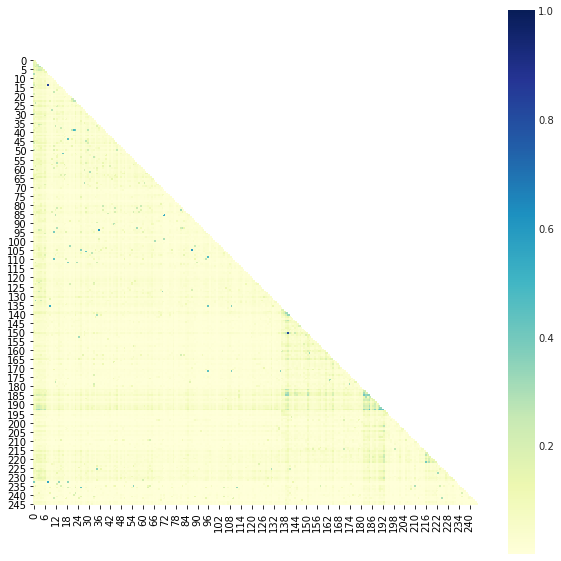

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
mask = np.zeros_like(sim_machado)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(sim_machado, cmap="YlGnBu", mask=mask, square=True)

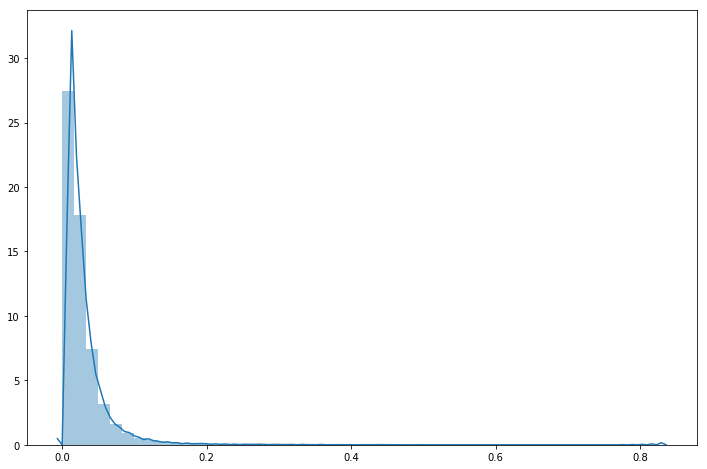

In [22]:
hist_data = []
for sim in sim_machado[np.triu_indices_from(sim_machado)]:
    if not(np.isclose(sim, 1) | np.isclose(sim, 0)):
        hist_data.append(sim)
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(hist_data)

Os textos do machado são muito distintos entre si.

### Exercício 3: Usando o Gensim
Instale o Gensim, se ainda não o tiver. Seguindo o início deste tutorial: https://radimrehurek.com/gensim/tut2.html, construa um corpus usando as classes do Gensim, mas com os textos de Machado.

In [23]:
from gensim import corpora, models, similarities

C:\Users\hugob\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [24]:
stemmer = PortugueseStemmer()

Como aprendemos na prática 1, vamos tokenizar, normalizar e remover *stopwords* dos textos.

In [25]:
filepath = './'
dict_file = 'vocabulario.dict'
try:
    dicionario = corpora.Dictionary.load(filepath+dict_file)
except:
    stem_textos = []
    c = Counter([])
    for texto in tok_textos:
        tstem = [stemmer.stem(token) for token in texto]
        c.update(tstem)
        stem_textos.append(tstem)
    stem_textos = [[token for token in t if c[token]>1] for t in stem_textos]
    dicionario = corpora.Dictionary(stem_textos)
    dicionario.save('vocabulario.dict')

corpus_file = 'machado.mm'
try:
    corpus = corpora.MmCorpus(filepath+corpus_file)
except:
    try:
        corpus = [dicionario.doc2bow(d) for d in stem_textos]
    except:
        stem_textos = []
        c = Counter([])
        for texto in tok_textos:
            tstem = [stemmer.stem(token) for token in texto]
            c.update(tstem)
            stem_textos.append(tstem)
        stem_textos = [[token for token in t if c[token]>1] for t in stem_textos]
        corpus = [dicionario.doc2bow(d) for d in stem_textos]
    finally:
        corpora.MmCorpus.serialize('machado.mm', corpus)

In [26]:
print(corpus)

MmCorpus(246 documents, 17950 features, 326706 non-zero entries)


### Exercício 4: Indexação Semântica Latente.

Ainda seguindo  o tutorial citado no exercício anterior, ajuste um modelo LSI para os documentos de machado. Interprete os resultados.

In [27]:
tfidf_model = models.TfidfModel(corpus)

In [28]:
def modelar_assunto(corpus, dicionario, num_topics=10, tfidf=tfidf_model):    
    corpus_tfidf = tfidf[corpus]
    return models.LsiModel(corpus_tfidf, id2word=dicionario, num_topics=num_topics)

In [29]:
lsi = modelar_assunto(corpus, dicionario, num_topics=20)

In [30]:
lsi.print_topics(num_words=4)

[(0, '0.305*"\x97" + 0.111*"sr" + 0.095*"poet" + 0.086*"luís"'),
 (1, '-0.387*"\x97" + 0.154*"sr" + 0.150*"crític" + -0.145*"luís"'),
 (2, '-0.296*"luís" + 0.265*"henriquet" + -0.149*"daniel" + -0.142*"tit"'),
 (3, '0.784*"henriquet" + 0.304*"juliã" + 0.151*"renan" + 0.094*"elis"'),
 (4, '0.570*"cecíl" + -0.439*"luís" + -0.182*"alves" + -0.126*"camil"'),
 (5, '0.403*"cecíl" + -0.292*"tit" + -0.231*"daniel" + 0.151*"luís"'),
 (6, '0.529*"daniel" + 0.332*"elis" + -0.187*"tit" + -0.182*"cecíl"'),
 (7, '-0.396*"daniel" + 0.352*"tit" + 0.275*"emíl" + 0.240*"valentim"'),
 (8, '0.392*"carlot" + -0.369*"tit" + 0.299*"romuald" + -0.225*"daniel"'),
 (9, '-0.341*"camil" + 0.291*"carlot" + -0.282*"jorg" + 0.206*"luís"'),
 (10, '0.224*"valentim" + 0.220*"luís" + -0.217*"eulál" + -0.212*"\x97"'),
 (11, '0.285*"alenc" + -0.249*"eulál" + -0.228*"alves" + -0.207*"jorg"'),
 (12, '-0.467*"beatriz" + -0.432*"eduard" + 0.251*"camil" + 0.233*"alenc"'),
 (13, '-0.261*"jorg" + 0.251*"valentim" + 0.230*"vicent

In [31]:
def q_to_lsi(q, lsi=lsi, tfidf_model=tfidf_model):
    qt = [stemmer.stem(t) for t in tokenize(q)]
    q_bow = dicionario.doc2bow(qt)
    q_tdidf = tfidf_model[q_bow]
    return lsi[q_tdidf] # convert the query to LSI space 

In [32]:
def buscar_assunto(q):
    q_lsi = q_to_lsi(q)
    return sorted(q_lsi, key=lambda item: -item[1])

In [33]:
buscar_assunto(q)[:5]

[(0, 0.008618891114004108),
 (17, 0.006496283609578366),
 (1, 0.005649409177568815),
 (10, 0.005525041284057897),
 (12, 0.004141627407471653)]

In [34]:
index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it

In [35]:
def similaridade_lsi(q, index=index):
    q_lsi = q_to_lsi(q)
    sims = index[q_lsi] # perform a similarity query against the corpus
    return sorted(enumerate(sims), key=lambda item: -item[1])

In [36]:
similaridade_lsi(q)

[(197, 0.7365862),
 (206, 0.7236478),
 (217, 0.70261943),
 (218, 0.686542),
 (160, 0.6622901),
 (216, 0.662187),
 (221, 0.65544474),
 (222, 0.6500711),
 (238, 0.6383945),
 (220, 0.6374838),
 (97, 0.6288326),
 (214, 0.6258195),
 (213, 0.62416196),
 (211, 0.6232642),
 (195, 0.59778),
 (147, 0.5938979),
 (175, 0.5927008),
 (194, 0.5865771),
 (155, 0.5778521),
 (167, 0.5775746),
 (200, 0.57660824),
 (159, 0.57163787),
 (154, 0.56666577),
 (143, 0.56458384),
 (162, 0.5620581),
 (150, 0.55725634),
 (169, 0.55513066),
 (156, 0.5547799),
 (207, 0.5515003),
 (181, 0.5480782),
 (176, 0.5477574),
 (74, 0.5241041),
 (152, 0.5231056),
 (202, 0.5223304),
 (196, 0.5199381),
 (166, 0.5183469),
 (219, 0.5154975),
 (187, 0.5111724),
 (146, 0.51072663),
 (189, 0.49506366),
 (186, 0.4843472),
 (198, 0.4840647),
 (201, 0.47637504),
 (188, 0.47608417),
 (170, 0.4713602),
 (142, 0.46818462),
 (77, 0.46354967),
 (184, 0.45686528),
 (173, 0.4552121),
 (165, 0.45490062),
 (85, 0.45130047),
 (153, 0.44476777),
 

Observa-se um resultado distinto da similaridade no Espaço Vetorial gerado por tf-idf.